In [1]:
#%pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
import random
import scipy
import glob
import os


labels_mcd = ['k2',
'k3',
'k4',
'k5',
'KS',
'KP',
'KN',
'kmenos4']

labels_luci = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']

# Importando experimentos

In [2]:
CIs = []
def convert_ci(ci):
    if type(ci) == str:
        ci_list = [float(i) for i in ci.split('_')]
        return ci_list
    else:
        ci_str = str(ci[0]) + '_' + str(ci[1]) + '_' + str(ci[2]) + '_' + str(ci[3])
        return ci_str
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../data/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = {}
    names_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']
    all_times = []
    # Load each remaining CSV file, reorder columns, and append to the list
    for idx,name in enumerate(names_files):
        df = pd.read_csv(csv_files[idx])  
        print(name)
        df = df[schema]  # Reorder columns to match the schema
        all_times.append(df['apa_t'].to_list())
        ci = df.iloc[0,:4].to_numpy()
        data_frames[name] = df
        CIs.append(convert_ci(ci))
    
    
    return data_frames,names_files,all_times
data_frames,file_list_exp,all_times = import_dfs()

print(data_frames.keys())
print("6-apa initial: ",[convert_ci(ci)[0] for ci in CIs])
print("ester initial: ",[convert_ci(ci)[2] for ci in CIs])
print([len(data_frame) for data_frame in [data_frames[name] for name in file_list_exp]])
print([data_frame['apa_t'].iloc[-1] for data_frame in [data_frames[name] for name in file_list_exp]])


25.45nh60ab20
25.46nh30ab30
25.47nh5ab80
5.100nh40ab80
5.102nh20ab40
5.103nh40ab30
5.106nh100ab40
5.107nh55ab55
5.109nh5ab55
5.110nh10ab55
5.112nh78ab35
5.48nh20ab80
5.80nh12ab40
5.81nh5ab30
nh60ab80
dict_keys(['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80'])
6-apa initial:  [20.0, 30.0, 80.0, 80.0, 40.5, 30.4, 40.038986354775815, 55.0, 55.0, 55.0, 32.5, 80.0, 38.75, 30.0, 80.0]
ester initial:  [60.0, 30.0, 5.0, 40.0, 21.75, 43.0, 100.04518072289156, 55.0, 5.0, 10.0, 78.0, 20.0, 12.0, 5.0, 60.0]
[11, 11, 10, 15, 13, 13, 12, 8, 8, 9, 10, 9, 11, 10, 11]
[490.0, 490.0, 240.0, 600.0, 540.0, 540.0, 360.0, 50.0, 60.0, 60.0, 360.0, 60.0, 410.0, 285.0, 600.0]


# Definindo modelo

In [3]:
Cez = 1

k2 = 187 / 60             # 1/min             
k3 = 44 / 60              # 1/min            
k4 = 235 / 60             # 1/min            
k5 = 0.15                 # 1/min            
KS = 380                  # milimolar            
KP = 95                   # milimolar            
KN = 43                   # milimolar            
kmenos4 = 217 / 60        # 1/min         

P_mcd = np.zeros(8)
P_mcd[0]   = k2 
P_mcd[1]   = k3    
P_mcd[2]   = k4      
P_mcd[3]   = k5      
P_mcd[4]   = KS     
P_mcd[5]   = KP      
P_mcd[6]   = KN      
P_mcd[7]   = kmenos4

Np_mcd = len(P_mcd)
print(P_mcd)

[3.11666667e+00 7.33333333e-01 3.91666667e+00 1.50000000e-01
 3.80000000e+02 9.50000000e+01 4.30000000e+01 3.61666667e+00]


In [4]:
# luci parameters

kcat1        = 0.178 #Constante catalítica do consumo do éster (mmol/i.u. per min)
 
kcat2        = 0.327 #Constante catalítica da hidrólise da amoxicilina (mmol/i.u. per min)
 
Km1          = 7.905 #Constante de Michaelis-Menten ou constante de afinidade para consumo do éster(mM) 
 
Km2          = 12.509 #Constante de Michaelis-Menten ou constante de afinidade para hidrólise da amoxicilina(mM)
 
Tmax         = 0.606 #Taxa de conversão máxima do complexo acil-enzima-núcleo em produto
 
Ken          = 14.350 #Constante de adsorção do 6-APA
 
kAB          = 3.78 #Constante de inibição do éster (POHPGME)(mM)
 
kAN          = 9.174 #Constante de inibição da amoxicilina (mM)
 
kAOH         = 10.907 #Constante de inibição do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 62.044 #Constante de inibição do 6-APA

P_luci = np.zeros(10)
P_luci[0]   = kcat1    
P_luci[1]   = kcat2    
P_luci[2]   = Km1      
P_luci[3]   = Km2      
P_luci[4]   = Tmax     
P_luci[5]   = Ken      
P_luci[6]   = kAB      
P_luci[7]   = kAN      
P_luci[8]   = kAOH     
P_luci[9]  = kNH 

Np_luci = len(P_luci)
print(P_luci)

[ 0.178  0.327  7.905 12.509  0.606 14.35   3.78   9.174 10.907 62.044]


In [5]:
def mcd_model(t,y, 
k2,
k3,
k4,
k5,
KS,
KP,
KN,
kmenos4,
):
    Cez = 1
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    RP = (Cez)/(k3 * KN + k4 * CNH + k5 * CNH) * (((k2 * k4 * CAB * CNH)/ (KS)) - ((kmenos4 * CAN * (k3 * KN + k5 * CNH))/KP))
    RB = (Cez * (k3 * KN + k5 * CNH) / (k3 * KN + k4 * CNH + k5 * CNH)) * (((k2 * CAB)/KS) - ((kmenos4 * CAN) / KP))
    RS = -(RP + RB)
    RNu = -(RP)

    dy = np.zeros(4)

    dy[0] =  RS       
    dy[1] =  RP
    dy[2] =  -(RP)  
    dy[3] = RB      
    
    return np.array(dy) 

In [6]:
def luci_model(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    Cez = 1

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy) 

In [8]:
# ODE15s solver
def ode15s_amox(P, CI, t, model):
    try:
        sol = scipy.integrate.solve_ivp(
            model, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(P)
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T

# Parâmetros estimados c/ 50000 cadeias

In [9]:
def import_dfs(N,model):
    # Path to the folder containing CSV files
    if model == 'mcd':
        folder_path = '../results/model_donald'
    elif model == 'luci':
        folder_path = '../results/model_luci_single_rep'
    else:
        raise SyntaxError('Use mcd or luci as model')
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, f'*{N}_*mean.csv'))
    # Initialize an empty list to hold dataframes
    data_frames_imp = []
    # Read the first CSV file to establish the schema
    if model == 'mcd':
        schema = ['k2',
              'k3',
              'k4',
              'k5',
              'KS',
              'KP',
              'KN',
              'kmenos4'
             ]
    else:
        schema = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']

    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        
        df = df[schema]  # Reorder columns to match the schema
        data_frames_imp.append(df)
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    print(csv_files)
    return data_frames_imp,csv_files 
data_frames_chains_mcd_50k,file_list_mcd_50k = import_dfs(50000,'mcd')
data_frames_chains_luci_50k,file_list_luci_50k = import_dfs(50000,'luci')

data_frames_chains_mcd_100k,file_list_mcd_100k = import_dfs(100000,'mcd')
data_frames_chains_luci_100k,file_list_luci_100k = import_dfs(100000,'luci')

['0_50000_donald_mean', '1_50000_donald_mean', '2_50000_donald_mean']
['0_50000_luci_mean', '1_50000_luci_mean', '50000_luci_mean']
['0_100000_donald_mean', '1_100000_donald_mean', '2_100000_donald_mean']
['0_100000_luci_mean', '1_100000_luci_mean', '2_100000_luci_mean']


## Guardar ensaios em um dataframe

In [10]:
ensaios_dfs_mcd_50k = {}
for assay in file_list_exp:
    ensaios_dfs_mcd_50k[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains_mcd_50k),data_frames_chains_mcd_50k[0].shape[1])),index=file_list_mcd_50k,columns=labels_mcd)

for idx,df in enumerate(data_frames_chains_mcd_50k):
    for row in df.index:
        ensaios_dfs_mcd_50k[file_list_exp[row]].loc[file_list_mcd_50k[idx],:] = df.iloc[row]

ensaios_dfs_mcd_100k = {}
for assay in file_list_exp:
    ensaios_dfs_mcd_100k[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains_mcd_100k),data_frames_chains_mcd_100k[0].shape[1])),index=file_list_mcd_100k,columns=labels_mcd)

for idx,df in enumerate(data_frames_chains_mcd_100k):
    for row in df.index:
        ensaios_dfs_mcd_100k[file_list_exp[row]].loc[file_list_mcd_100k[idx],:] = df.iloc[row]

ensaios_dfs_luci_50k = {}
for assay in file_list_exp:
    ensaios_dfs_luci_50k[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains_luci_50k),data_frames_chains_luci_50k[0].shape[1])),index=file_list_luci_50k,columns=labels_luci)

for idx,df in enumerate(data_frames_chains_luci_50k):
    for row in df.index:
        ensaios_dfs_luci_50k[file_list_exp[row]].loc[file_list_luci_50k[idx],:] = df.iloc[row]

ensaios_dfs_luci_100k = {}
for assay in file_list_exp:
    ensaios_dfs_luci_100k[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains_luci_100k),data_frames_chains_luci_100k[0].shape[1])),index=file_list_luci_100k,columns=labels_luci)

for idx,df in enumerate(data_frames_chains_luci_100k):
    for row in df.index:
        ensaios_dfs_luci_100k[file_list_exp[row]].loc[file_list_luci_100k[idx],:] = df.iloc[row]


## Visualização da performance

In [11]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-ok','-ok','-ok','-ok']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-10, val_x[:, idx].max()+10])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

## Avaliar os parâmetros universalmente

In [70]:
import seaborn as sns
import copy

eval_set = ['25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30']
out_set = ['nh60ab80','25.45nh60ab20']

def eval_performance(P,model,plot=False):
    
    total_error = 0
    all_error = []
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    for exp_name in eval_set:
        x_target = data_frames[exp_name].loc[:,x_names].to_numpy()
        t_target = data_frames[exp_name]['apa_t'].to_numpy()
        
        ic = x_target[0]
        
        sol_val = ode15s_amox(P,ic,t_target,model)
        x_model = sol_val
 
        error_per_variable = np.sqrt(np.mean((x_target - x_model) ** 2, axis=0))
        # Compute the mean of the observed values for each variable (mean across rows)
        mean_x_target_per_variable = np.mean(x_target, axis=0)

        # Compute relative RMSE (rRMSE) for each variable
        rRMSE_per_variable = (error_per_variable / mean_x_target_per_variable) * 100
        #print(rRMSE_per_variable)

        rMSRE = np.mean(rRMSE_per_variable)
        #print(rMSRE)

        total_error += rMSRE
        all_error.append(rMSRE)
        total_error += rMSRE

        if plot:
            print(f'Error {exp_name} : {error_per_variable}')
        
            model_eval(x_model,t_target,x_target,t_target)
            
    print('\ntotal error: ',total_error,'\n')
        
    return total_error,all_error

def eval_all(P_new,model):
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    total_error = 0
    idx = 0
    surface_error = np.zeros((len(data_frames),3))
    for exp_name in eval_set:
        x_target = data_frames[exp_name].loc[:,x_names].to_numpy()
        t_target = data_frames[exp_name]['apa_t'].to_numpy()
    
        ic = x_target[0]
        
        surface_error[idx,1] = ic[0] # ester
        surface_error[idx,2] = ic[2] # apa

        sol_val = ode15s_amox(P_new,ic,t_target,model)
        x_model = sol_val
        
        error_per_variable = np.sqrt(np.mean((x_target - x_model) ** 2, axis=0))
        # Compute the mean of the observed values for each variable (mean across rows)
        mean_x_target_per_variable = np.mean(x_target, axis=0)

        # Compute relative RMSE (rRMSE) for each variable
        rRMSE_per_variable = (error_per_variable / mean_x_target_per_variable) * 100
        
        rMSRE = np.mean(rRMSE_per_variable)
         
        total_error += rMSRE

        surface_error[idx,0] = rMSRE
        
        print(f'{ic} tmax_{int(t_target[-1])} :\t{rMSRE}')
        idx+=1
        
    surfacedf = pd.DataFrame(surface_error,columns=['RMSE','Ester','APA'])
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=surfacedf, x='Ester', y='APA', size='RMSE', hue='RMSE', sizes=(10, 400), hue_norm=(0, 2.5),legend='full')
    plt.legend(title='Error Value', loc='upper right', bbox_to_anchor=(-0.15, 1))
    print(f'Total error: {total_error/len(data_frames)}')

In [65]:
ensaios_dfs_luci_50k['25.45nh60ab20']

,kcat1,kcat2,Km1,Km2,Tmax,Ken,kAB,kAN,kAOH,kNH
0_50000_luci_mean,0.019559,0.431745,6.451931,9.211043,0.359442,20.461443,0.407949,3.259543,20.073198,107.950468
1_50000_luci_mean,0.016247,0.069428,2.610514,5.724109,0.324680,12.081386,0.381424,2.834911,1.373051,28.929975
50000_luci_mean,0.015923,0.284061,2.486521,2.097994,0.543976,4.385607,0.611437,1.244239,2.893281,18.499101


In [91]:
import seaborn as sns
import copy


def find_best(N=50000,model='mcd'):
    indexes = copy.copy(file_list_exp) 
    
    grid = pd.DataFrame(np.zeros((len(eval_set),len(eval_set))),index=eval_set,columns=eval_set)
    # Para cada experimento
    for idx,name in enumerate(eval_set):
        if N == 50000:
            if model=='mcd':
                df = ensaios_dfs_mcd_50k[name]
            if model == 'luci':
                df = ensaios_dfs_luci_50k[name]
        else:
            if model=='mcd':
                df = ensaios_dfs_mcd_100k[name]
            if model == 'luci':
                df = ensaios_dfs_luci_100k[name]
                
        all_errors = []
        mean_errors = []

        # Para cada iteração do experimento
        for iter in range(df.shape[0]):
            # Coletar os parametros e avaliar perfomance
            P = df.iloc[iter,:].to_numpy()
            if model == 'mcd':
                tot_error, all_error = eval_performance(P,model=mcd_model)
            else:
                tot_error, all_error = eval_performance(P,model=luci_model)

            # Armazenar os erros associados a cada experimento desta iteração
            all_errors.append(all_error)

            # Armazenar o erro médio dessa iteração
            # mean_error = (tot_error) / (len(all_error))
            # mean_errors.append(mean_error)
        # Média dos erros em cada experimento de todas as iterações
        all_error_mean = np.mean(all_errors,axis=0)

        # Média do erro média das iterações

        for i,test_name in enumerate(eval_set):
            grid.loc[test_name,name] = all_error_mean[i]
        grid.loc['mean', name] = np.mean(grid.iloc[:-1,idx])
    return grid

best_luci_50k = find_best(50000,'luci')
best_luci_100k = find_best(100000,'luci')
best_mcd_50k = find_best(50000,'mcd')
best_mcd_100k = find_best(100000,'mcd')


total error:  1130.6834071120422 


total error:  1162.8883592513205 


total error:  1218.594769607221 


total error:  1598.3570778276269 


total error:  1601.2783154102144 


total error:  1654.9999605293415 


total error:  813.1913436404849 


total error:  924.7771874646039 


total error:  1104.0483696473411 


total error:  990.9875911307562 


total error:  1116.1792271622214 


total error:  1105.6819790272643 


total error:  947.5463094336526 


total error:  843.0440627150431 


total error:  1016.5321718964697 


total error:  1515.0046696008435 


total error:  1397.375626661857 


total error:  1421.9116874385932 


total error:  1401.0789738049707 


total error:  759.9010509583757 


total error:  943.9267470724571 


total error:  1632.2515200679654 


total error:  1080.6965953379438 


total error:  1341.2236406973918 


total error:  1012.6896399828046 


total error:  1364.7165342761214 


total error:  1108.880439608843 


total error:  1002.604488975101 


to

In [92]:
print(best_luci_50k)

                25.46nh30ab30  25.47nh5ab80  5.100nh40ab80  5.102nh20ab40  \
25.46nh30ab30        4.603162    108.422353      50.904262      72.168338   
25.47nh5ab80        59.185972      3.948032      55.792048      48.815148   
5.100nh40ab80       34.175246     91.940603       6.149264      35.019183   
5.102nh20ab40       79.889041     44.495234      35.850463      11.352052   
5.103nh40ab30       48.961444     47.754754      14.716982      23.707914   
5.106nh100ab40      27.996587    186.153633      66.035709     109.654316   
5.107nh55ab55       26.660987     68.116694       6.945334      21.208970   
5.109nh5ab55        41.198360     15.140798      42.267039      45.017109   
5.110nh10ab55       46.158739     25.583088      24.218235      14.152960   
5.112nh78ab35       16.434642    102.396714      35.228028      60.866978   
5.48nh20ab80        54.027920      8.172913      36.413410      27.039355   
5.80nh12ab40        64.549038     59.479910      36.532508      23.832575   

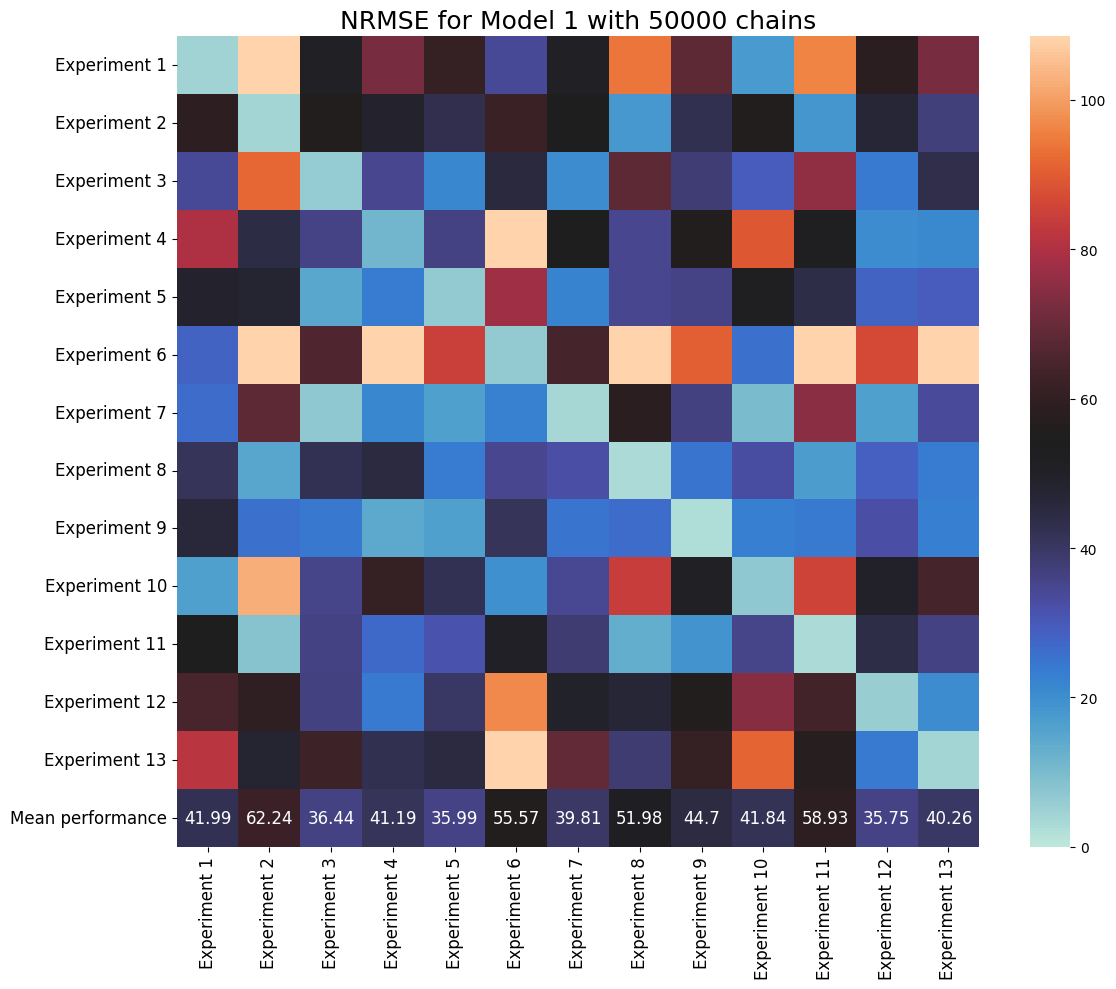

In [93]:
plt.figure(figsize=(12, 10))

y_ticks = [f'Experiment {i+1}' for i in range(13)] + ['Mean performance']
annot_array = np.empty(best_luci_50k.shape, dtype=object)
# Create an annotation array with NaN values except for the last row
annot_array[:] = ''  # Fill the entire array with empty strings
annot_array[-1, :] = np.round(best_luci_50k.iloc[-1, :], 2)  # Only the last row gets the values

# Plot the heatmap
ax = sns.heatmap(best_luci_50k, annot=annot_array, cmap='icefire', vmin=0, vmax=best_luci_50k.max().mean(), linewidths=0.0,
                 annot_kws={'fontsize': 12}, xticklabels=[f'Experiment {i+1}' for i in range(13)], yticklabels=y_ticks, fmt='')

ax.set_title("NRMSE for Model 1 with 50000 chains", fontsize=18)
#ax.set_xlabel("Experiment used for estimation", fontsize=18)
#ax.set_ylabel("Experiment used for testing", fqontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(f'../results/compare/heatmaps/heatmap_luci_50k', bbox_inches='tight')

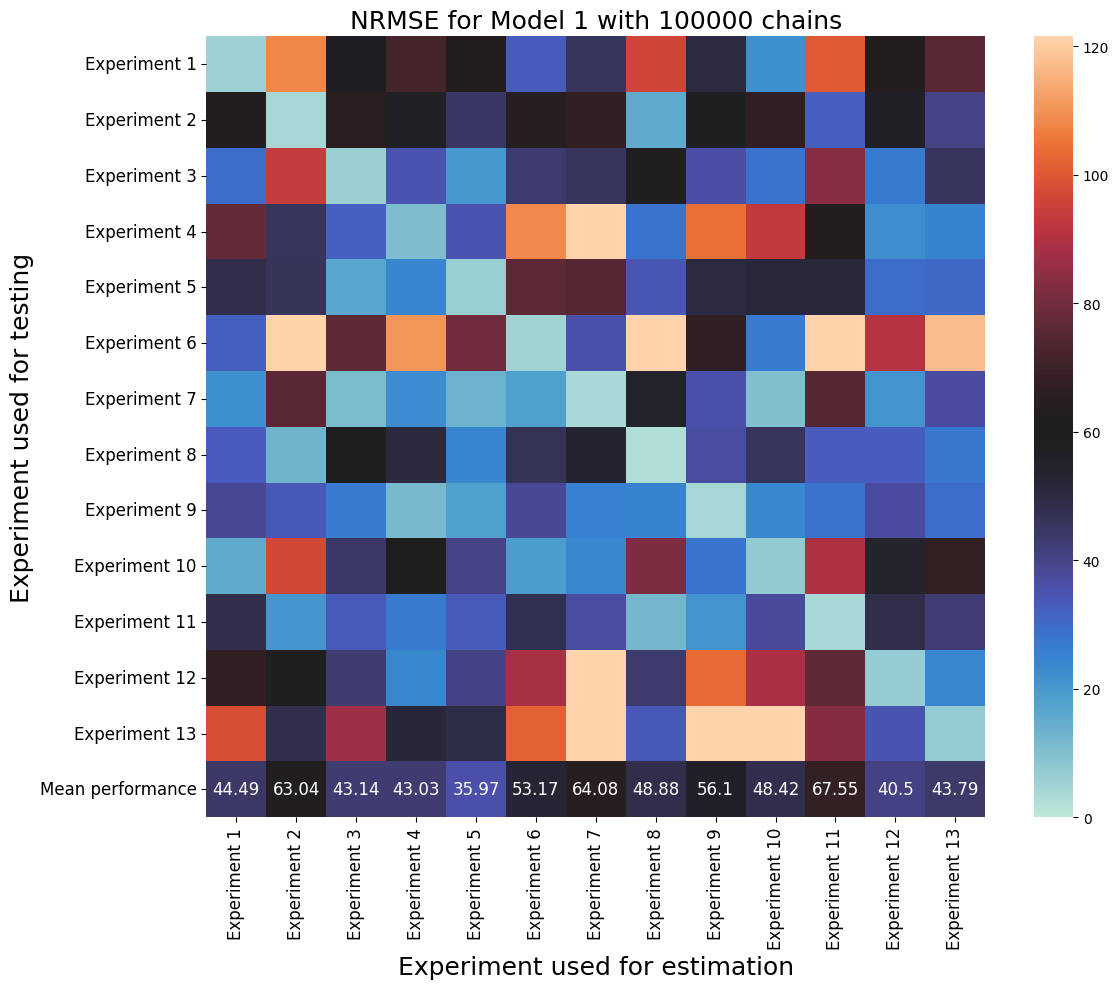

In [83]:
plt.figure(figsize=(12, 10))

y_ticks = [f'Experiment {i+1}' for i in range(13)] + ['Mean performance']
annot_array = np.empty(best_luci_100k.shape, dtype=object)
# Create an annotation array with NaN values except for the last row
annot_array[:] = ''  # Fill the entire array with empty strings
annot_array[-1, :] = np.round(best_luci_100k.iloc[-1, :], 2)  # Only the last row gets the values

# Plot the heatmap
ax = sns.heatmap(best_luci_100k, annot=annot_array, cmap='icefire', vmin=0, vmax=best_luci_100k.max().mean(), linewidths=0.0,
                 annot_kws={'fontsize': 12}, xticklabels=[f'Experiment {i+1}' for i in range(13)], yticklabels=y_ticks, fmt='')

ax.set_title("NRMSE for Model 1 with 100000 chains", fontsize=18)
ax.set_xlabel("Experiment used for estimation", fontsize=18)
ax.set_ylabel("Experiment used for testing", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(f'../results/compare/heatmaps/heatmap_luci_100k', bbox_inches='tight')

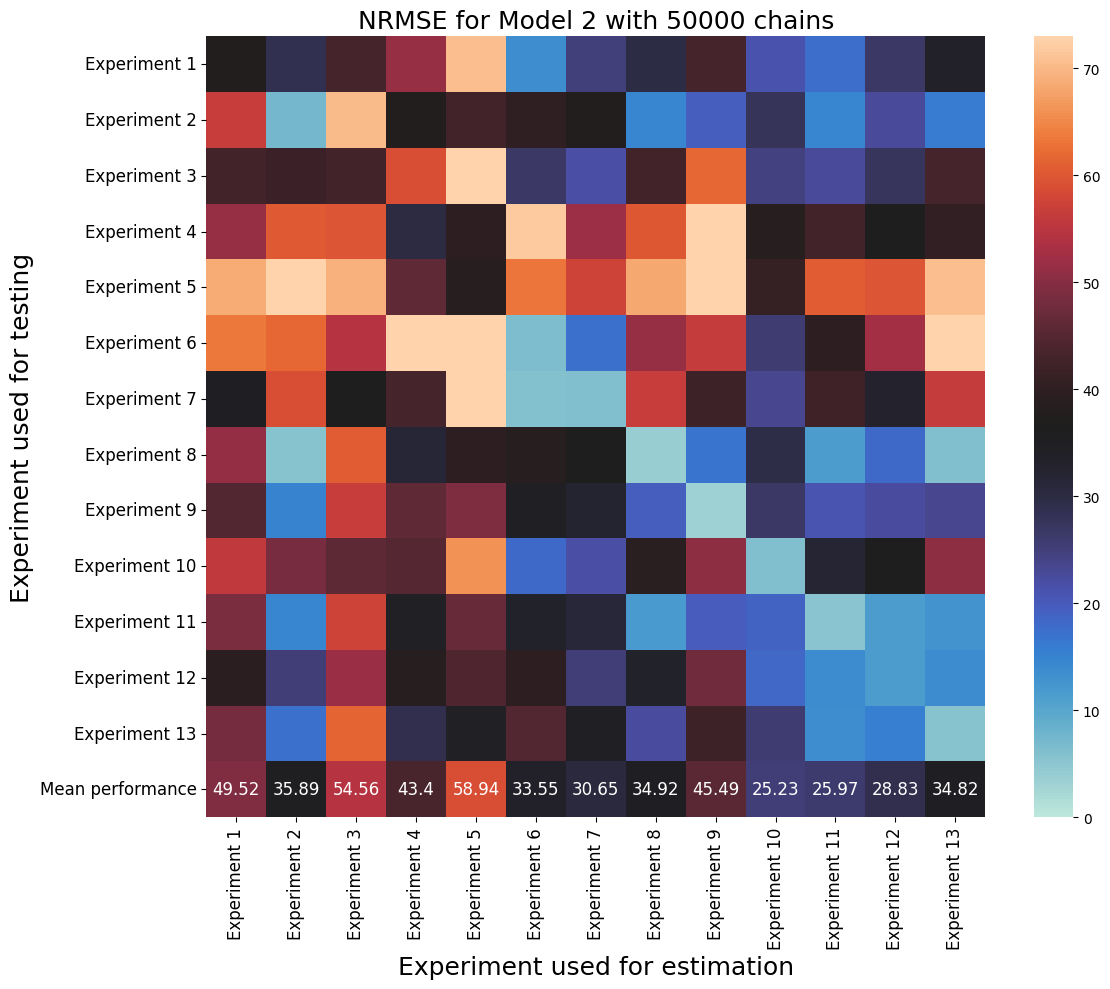

In [84]:
plt.figure(figsize=(12, 10))

y_ticks = [f'Experiment {i+1}' for i in range(13)] + ['Mean performance']
annot_array = np.empty(best_mcd_50k.shape, dtype=object)
# Create an annotation array with NaN values except for the last row
annot_array[:] = ''  # Fill the entire array with empty strings
annot_array[-1, :] = np.round(best_mcd_50k.iloc[-1, :], 2)  # Only the last row gets the values

# Plot the heatmap
ax = sns.heatmap(best_mcd_50k, annot=annot_array, cmap='icefire', vmin=0, vmax=best_mcd_50k.max().mean(), linewidths=0.0,
                 annot_kws={'fontsize': 12}, xticklabels=[f'Experiment {i+1}' for i in range(13)], yticklabels=y_ticks, fmt='')

ax.set_title("NRMSE for Model 2 with 50000 chains", fontsize=18)
ax.set_xlabel("Experiment used for estimation", fontsize=18)
ax.set_ylabel("Experiment used for testing", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(f'../results/compare/heatmaps/heatmap_mcd_50k', bbox_inches='tight')

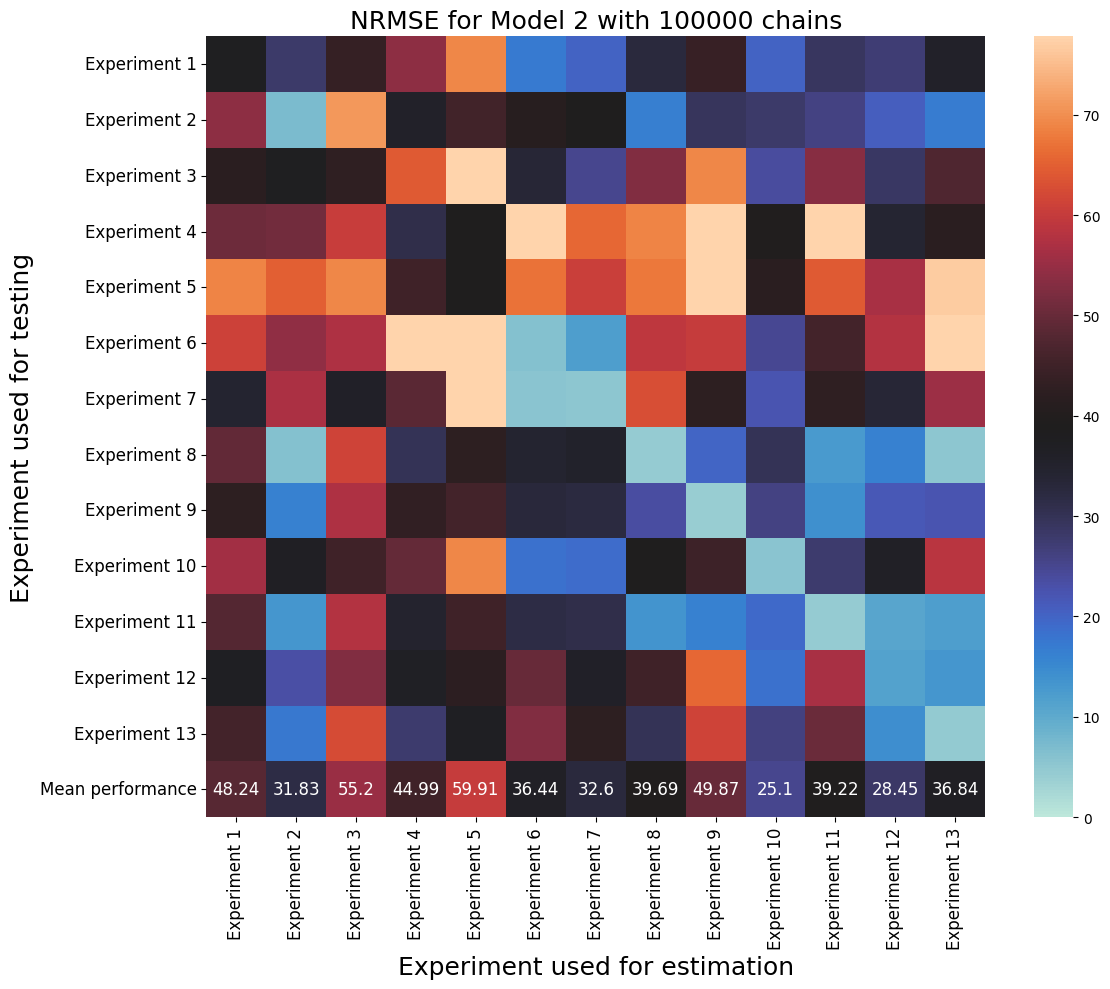

In [86]:
plt.figure(figsize=(12, 10))

y_ticks = [f'Experiment {i+1}' for i in range(13)] + ['Mean performance']
annot_array = np.empty(best_luci_50k.shape, dtype=object)
# Create an annotation array with NaN values except for the last row
annot_array[:] = ''  # Fill the entire array with empty strings
annot_array[-1, :] = np.round(best_mcd_100k.iloc[-1, :], 2)  # Only the last row gets the values

# Plot the heatmap
ax = sns.heatmap(best_mcd_100k, annot=annot_array, cmap='icefire', vmin=0, vmax=best_mcd_100k.max().mean(), linewidths=0.0,
                 annot_kws={'fontsize': 12}, xticklabels=[f'Experiment {i+1}' for i in range(13)], yticklabels=y_ticks, fmt='')

ax.set_title("NRMSE for Model 2 with 100000 chains", fontsize=18)
ax.set_xlabel("Experiment used for estimation", fontsize=18)
ax.set_ylabel("Experiment used for testing", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(f'../results/compare/heatmaps/heatmap_mcd_100k', bbox_inches='tight')

In [94]:
for i in range(len(eval_set)):
    print(eval_set[i])
    for j in range(3):
        par = copy.deepcopy(ensaios_dfs_luci_50k[eval_set[i]].iloc[j,:].to_list())
        #eval_performance(P,plot=False)
        eval_performance(par,plot=False,model=luci_model)
# eval_all(par)

#print(file_list_exp[n])
#for idx,par in enumerate(par):
#    print(labels[idx],': ',par)

25.46nh30ab30

total error:  1130.6834071120422 


total error:  1162.8883592513205 


total error:  1218.594769607221 

25.47nh5ab80

total error:  1598.3570778276269 


total error:  1601.2783154102144 


total error:  1654.9999605293415 

5.100nh40ab80

total error:  813.1913436404849 


total error:  924.7771874646039 


total error:  1104.0483696473411 

5.102nh20ab40

total error:  990.9875911307562 


total error:  1116.1792271622214 


total error:  1105.6819790272643 

5.103nh40ab30

total error:  947.5463094336526 


total error:  843.0440627150431 


total error:  1016.5321718964697 

5.106nh100ab40

total error:  1515.0046696008435 


total error:  1397.375626661857 


total error:  1421.9116874385932 

5.107nh55ab55

total error:  1401.0789738049707 


total error:  759.9010509583757 


total error:  943.9267470724571 

5.109nh5ab55

total error:  1632.2515200679654 


total error:  1080.6965953379438 


total error:  1341.2236406973918 

5.110nh10ab55

total error:  1012.

5.100nh40ab80

total error:  893.0718598225683 


total error:  813.1913436404849 

[30.  0. 30.  0.] tmax_490 :	55.70935692517402
[80.  0.  5.  0.] tmax_240 :	44.17872436056283
[80.  0. 40.  0.] tmax_600 :	7.4082119833102835
[40.5         0.         21.75        3.37262013] tmax_540 :	31.53729311682939
[30.4   0.   43.    2.55] tmax_540 :	10.132732394298483
[4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00] tmax_360 :	60.60865440097312
[55.        0.       55.        0.623377] tmax_50 :	6.406057061311266
[55.  0.  5.  0.] tmax_60 :	28.94073691116991
[55.  0. 10.  0.] tmax_60 :	28.646563878909497
[32.5  0.  78.   2.5] tmax_360 :	33.47828134923467
[80.  0. 20.  0.] tmax_60 :	40.17353534010729
[38.75  0.   12.    1.4 ] tmax_410 :	27.661545598905107
[30.  0.  5.  0.] tmax_285 :	31.713978499456495
Total error: 27.10637812134949
25.47nh5ab80
kcat1 :  0.1387559296658525
kcat2 :  0.5697196090047794
Km1 :  2.0632025779611216
Km2 :  8.585469990176154
Tmax :  0.8714208539631354
Ken : 

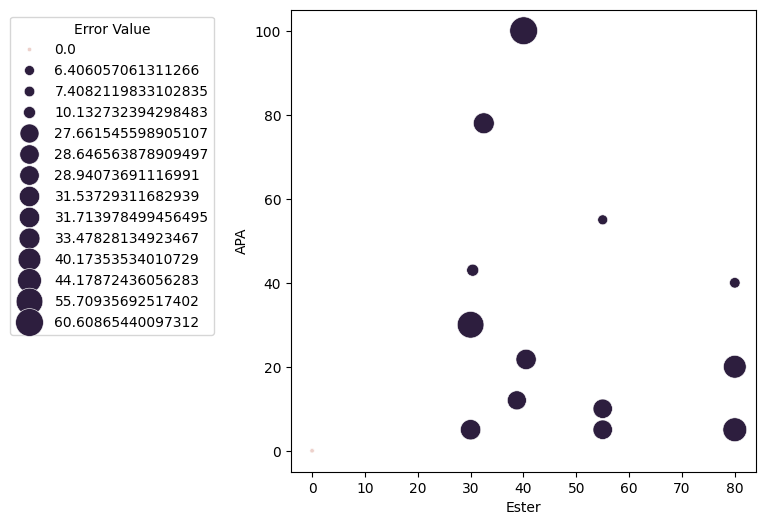

In [96]:
n = 2
par = copy.deepcopy(ensaios_dfs_luci_50k[eval_set[n]].iloc[0,:].to_list())
print(eval_set[n])
eval_performance(P_luci,plot=False,model=luci_model)
eval_performance(par,plot=False,model=luci_model)
eval_all(par,model=luci_model)

print(file_list_exp[n])
for idx,par in enumerate(par):
    print(labels_luci[idx],': ',par)

5.112nh78ab35

total error:  2793.6886190500354 


total error:  640.489993761274 

[30.  0. 30.  0.] tmax_490 :	18.469345204649734
[80.  0.  5.  0.] tmax_240 :	26.722382022020923
[80.  0. 40.  0.] tmax_600 :	22.364904072614223
[40.5         0.         21.75        3.37262013] tmax_540 :	41.568462071370526
[30.4   0.   43.    2.55] tmax_540 :	42.38831947380101
[4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00] tmax_360 :	25.61476688959211
[55.        0.       55.        0.623377] tmax_50 :	22.49279616814178
[55.  0.  5.  0.] tmax_60 :	28.097638599799794
[55.  0. 10.  0.] tmax_60 :	24.231009819436046
[32.5  0.  78.   2.5] tmax_360 :	5.280717096201061
[80.  0. 20.  0.] tmax_60 :	18.166571753548777
[38.75  0.   12.    1.4 ] tmax_410 :	18.549031677051378
[30.  0.  5.  0.] tmax_285 :	26.299052032409723
Total error: 21.34966645870914
5.48nh20ab80
k2 :  0.7117084846509176
k3 :  0.5293636724632858
k4 :  0.1802460080707195
k5 :  0.0638717488454972
KS :  192.66689800372808
KP :  134.8

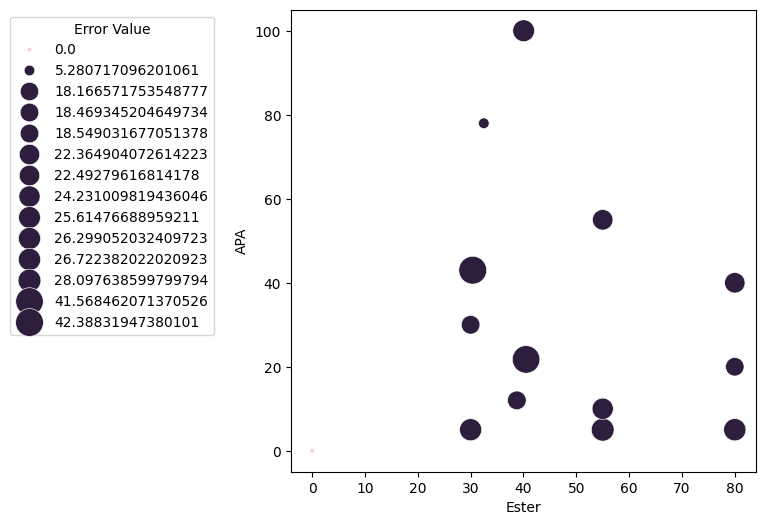

In [99]:
n = -4
par = copy.deepcopy(ensaios_dfs_mcd_50k[eval_set[n]].iloc[1,:].to_list())
print(eval_set[n])
eval_performance(P_mcd,plot=False,model=mcd_model)
eval_performance(par,plot=False,model=mcd_model)
eval_all(par,model=mcd_model)

print(file_list_exp[n])
for idx,par in enumerate(par):
    print(labels_mcd[idx],': ',par)

# Plot concentration vs Time with confidence intervals

In [100]:
data_frames[file_list_exp[1]]

,ester_mm,amox_mm,apa_mm,aoh_mm,apa_t
0,30.000000,0.000000,30.000000,0.000000,0.0
1,27.113396,1.089985,29.018032,2.063781,30.0
2,26.253156,1.847759,28.166685,2.484511,60.0
3,25.329938,2.556583,27.500346,2.901796,90.0
4,24.088727,3.115446,26.893091,3.945534,120.0
5,20.736206,4.387875,25.675897,5.829868,187.5
6,17.785522,4.896507,25.166740,7.936516,240.0
7,17.056016,5.323650,24.749012,8.676316,300.0
8,13.938295,5.714006,24.392560,11.015483,360.0
9,12.002555,5.759691,24.285014,13.021782,420.0


In [101]:
def plot_with_ci(path,model,path_to_save):
    # Load the output_par data from the .npz file
    data = np.load(path)
    output_par = data['arr_0'] # Ensure this is the correct key in the .npz file

    # Mask for missing values (0, inf, -inf, nan)
    mask = np.isinf(output_par) | np.isnan(output_par) | (output_par == 0)

    # Calculate the mean along the specified axis, ignoring nan and inf
    # Use np.nanmean to ignore NaNs, and replace inf/-inf with nan first
    mean_values = np.nanmean(np.where(np.isinf(output_par), np.nan, output_par), axis=0)
    # Mean values along axis 0

    # Replace missing values with the computed mean along the axis
    # Using np.where to replace only the masked positions with the mean values
    output_par[mask] = np.take(mean_values, np.where(mask)[1])
    # Assuming you have the necessary CIs (Initial Conditions), all_times, data_frames from somewhere
    N = output_par.shape[0]  # Number of iterations in the MCMC process
    N_samples = len(CIs)  # Number of samples/experiments

    # Recompute IC_inf, IC_sup
    IC = 0.99
    xaux = (1 - IC) / 2
    IC_inf = xaux
    IC_sup = 1 - xaux

    amostra = N - int(0.9 * N) + 1
    amostras = []  # Recompute from loaded data

    for i in range(N_samples):
        t = all_times[i]
        inst_amostra = np.zeros((output_par.shape[0], len(t), 4))
        print(file_list_exp[i])
        for idx in range(output_par.shape[0]):
            if idx % 50 == 0:
                print(idx,' / ',N,end='\r')
            paux = output_par[idx, :]

            # Simulate the model
            Y = ode15s_amox(paux, convert_ci(CIs[i]), t,model)
            inst_amostra[idx, :, 0] = Y[:, 0]
            inst_amostra[idx, :, 1] = Y[:, 1]
            inst_amostra[idx, :, 2] = Y[:, 2]
            inst_amostra[idx, :, 3] = Y[:, 3]

        amostras.append(inst_amostra)

    # Recompute means, percentiles, and store them
    AB_media, AN_media, NH_media, AOH_media = [], [], [], []
    AB_sup, AN_sup, NH_sup, AOH_sup = [], [], [], []
    AB_inf, AN_inf, NH_inf, AOH_inf = [], [], [], []

    for i in range(len(CIs)):
        t = all_times[i]
        amostra = amostras[i]

        AB_mean = np.mean(amostra[:, :, 0], axis=0)
        AB_inferior = np.percentile(amostra[:, :, 0], IC_inf * 100, axis=0)
        AB_superior = np.percentile(amostra[:, :, 0], IC_sup * 100, axis=0)

        NH_mean = np.mean(amostra[:, :, 2], axis=0)
        NH_inferior = np.percentile(amostra[:, :, 2], IC_inf * 100, axis=0)
        NH_superior = np.percentile(amostra[:, :, 2], IC_sup * 100, axis=0)

        AN_mean = np.mean(amostra[:, :, 1], axis=0)
        AN_inferior = np.percentile(amostra[:, :, 1], IC_inf * 100, axis=0)
        AN_superior = np.percentile(amostra[:, :, 1], IC_sup * 100, axis=0)

        AOH_mean = np.mean(amostra[:, :, 3], axis=0)
        AOH_inferior = np.percentile(amostra[:, :, 3], IC_inf * 100, axis=0)
        AOH_superior = np.percentile(amostra[:, :, 3], IC_sup * 100, axis=0)

        AB_media.append(AB_mean)
        NH_media.append(NH_mean)
        AB_inf.append(AB_inferior)
        AB_sup.append(AB_superior)
        NH_inf.append(NH_inferior)
        NH_sup.append(NH_superior)
        AN_media.append(AN_mean)
        AOH_media.append(AOH_mean)
        AN_inf.append(AN_inferior)
        AN_sup.append(AN_superior)
        AOH_inf.append(AOH_inferior)
        AOH_sup.append(AOH_superior)

    # Plot the graphs
    results_dir = path_to_save
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for i in range(len(CIs)):
        t = all_times[i]
        style = ['or','ob','vg','vk']
        mstyle = ['-r','-b','-g','-k']
        medidas = [
            [NH_media[i], NH_inf[i], NH_sup[i]],
            [AB_media[i], AB_inf[i], AB_sup[i]],
            [AN_media[i], AN_inf[i], AN_sup[i]],
            [AOH_media[i], AOH_inf[i], AOH_sup[i]]
        ]
        names = ['6-APA','POH-PGME','Amoxicillin','POHPG']
        schema = ['apa_mm','ester_mm','amox_mm','aoh_mm']
  
        fig, ax = plt.subplots(2, 1, figsize=(8, 8))
        for idx, axis in enumerate(ax.flatten()):
            df = data_frames[file_list_exp[i]].loc[:,schema]
            sname = names[idx]
            sname2 = names[idx+2]
            medida = medidas[idx]
            medida2 = medidas[idx+2]
            axis.plot(t, df.iloc[:, idx].to_numpy(), style[idx], label=sname,markersize=8)
            axis.plot(t, medida[0], mstyle[idx],label='Model prediction')
            axis.plot(t, medida[1],'r', linestyle='--', dashes=(5, 5),linewidth=0.5)
            axis.plot(t, medida[2],'r', linestyle='--', dashes=(5, 5),linewidth=0.5) 
            axis.plot(t, df.iloc[:, idx+2].to_numpy(), style[idx+2], label=sname2,markersize=8)
            axis.plot(t, medida2[0], mstyle[idx+2],label='Model prediction')
            axis.plot(t, medida2[1],'r', linestyle='--', dashes=(5, 5),linewidth=0.5)
            axis.plot(t, medida2[2],'r', linestyle='--', dashes=(5, 5),linewidth=0.5)

            axis.tick_params(axis='both', which='major', direction='in', length=6, width=1)
            axis.tick_params(axis='both', which='minor', direction='in', length=4, width=1)

            # Enabling and customizing minor ticks
            axis.minorticks_on()

            # Ensuring ticks appear on all four sides of the plot
            axis.tick_params(top=True, bottom=True, left=True, right=True, which='both')
            axis.set_xlim([t[0],t[-1]+t[1]])
            axis.set_ylim([
                min(
                    min(medida[1]),
                    min(medida2[1])
                ) - 5,
                max(
                    max(medida[2]),
                    max(medida2[2])
                ) + 5
                ])
            axis.set_xlabel('Time (min)')
            axis.set_ylabel(f'Concentration (mm)')
            axis.legend()
        print(f"Saving figure to {os.path.join(results_dir, f'5.100nh40ab80_{N}_{file_list_exp[i]}_mcmc.png')}")
        fig.savefig(os.path.join(results_dir, f"5.100nh40ab80_{N}_{file_list_exp[i]}_mcmc.png"), dpi=300)
        print("Figure saved successfully.")   


25.45nh60ab20
25.46nh30ab30
25.47nh5ab801
5.100nh40ab80
5.102nh20ab40
5.103nh40ab30
5.106nh100ab40
5.107nh55ab55
5.109nh5ab551
5.110nh10ab55
5.112nh78ab35
5.48nh20ab801
5.80nh12ab401
5.81nh5ab3001
nh60ab80 5001
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_25.45nh60ab20_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_25.46nh30ab30_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_25.47nh5ab80_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_5.100nh40ab80_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_5.102nh20ab40_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_5.103nh40ab30_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//model_luci\5.100nh40ab80_5001_5.106nh

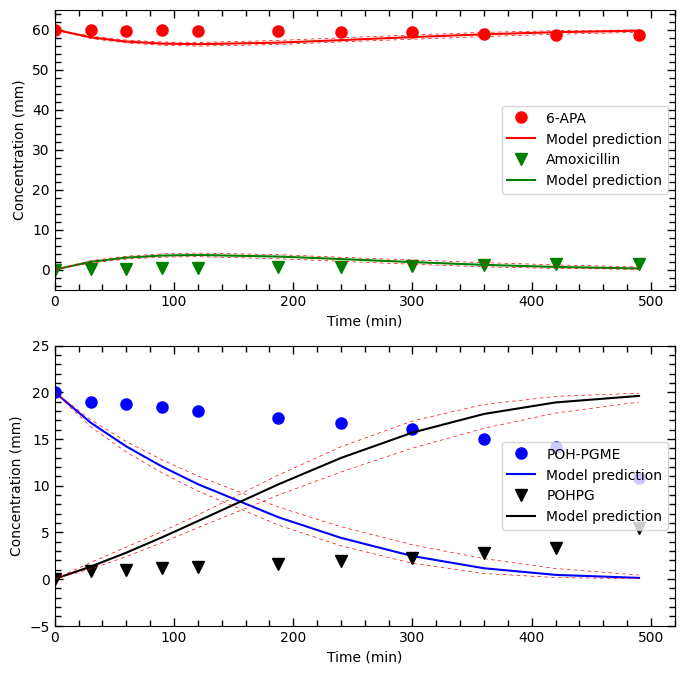

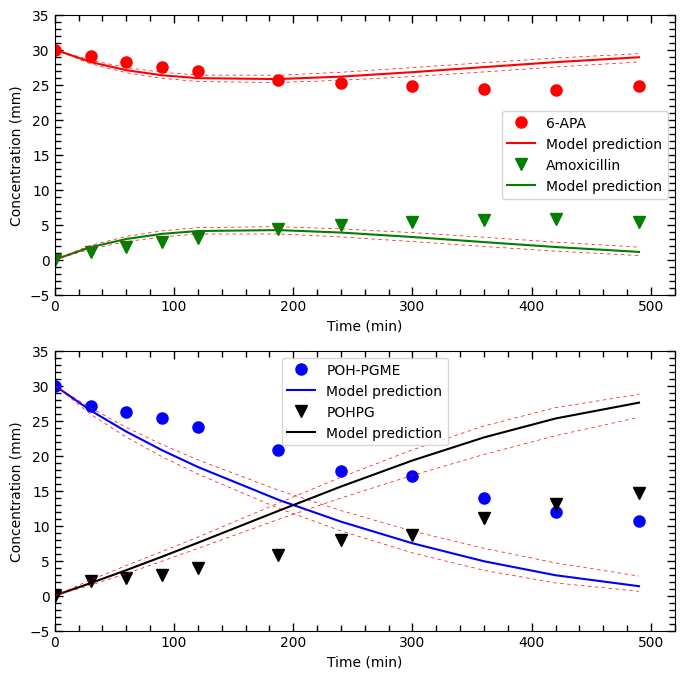

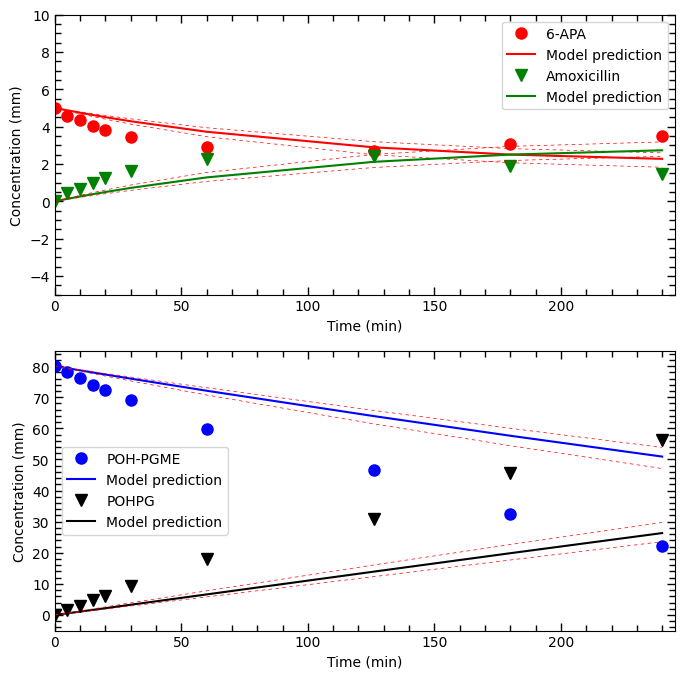

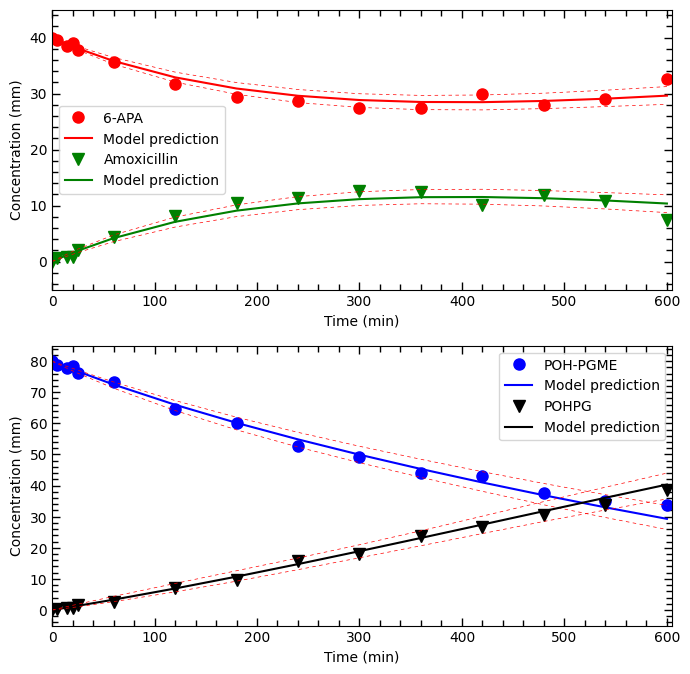

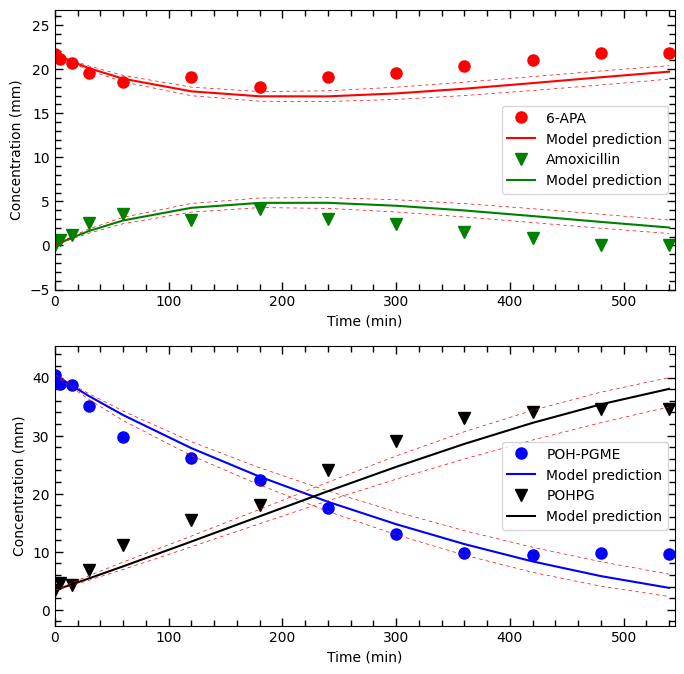

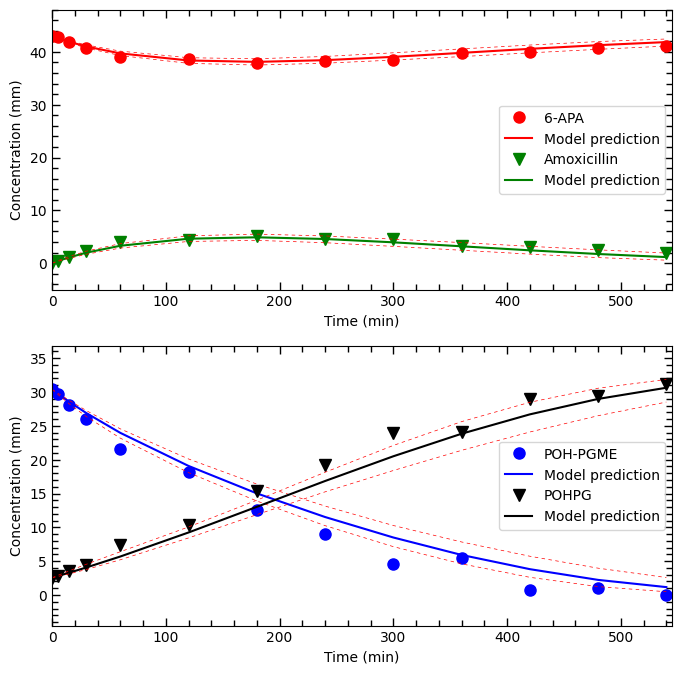

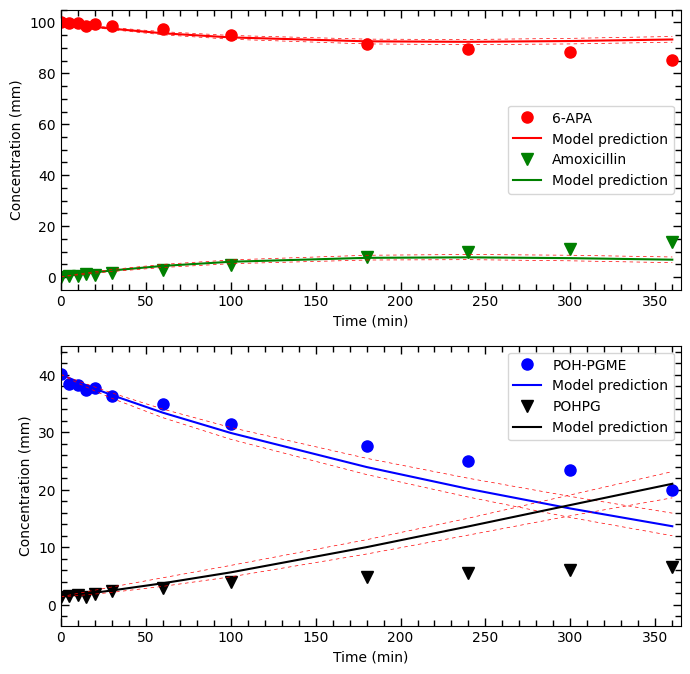

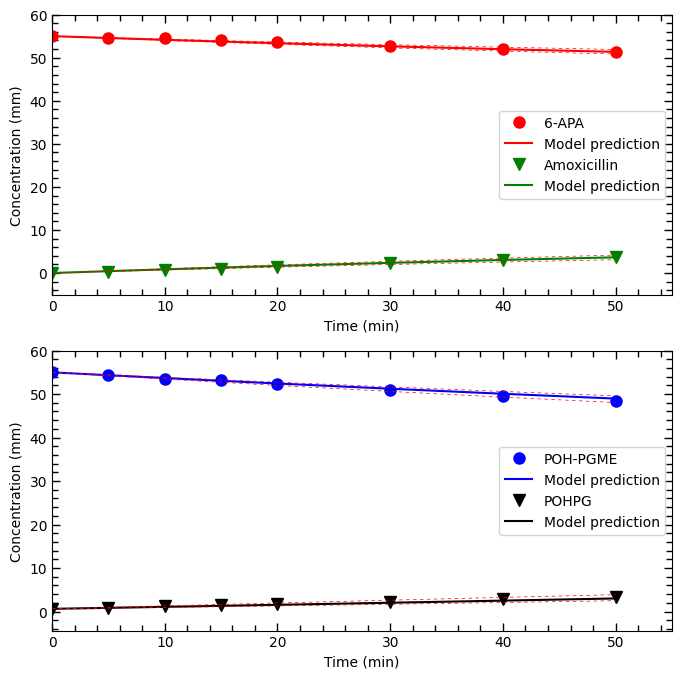

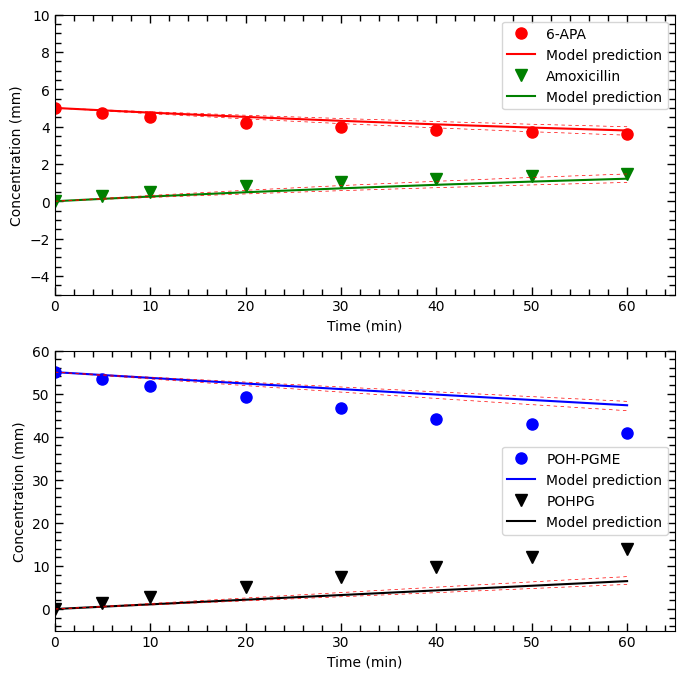

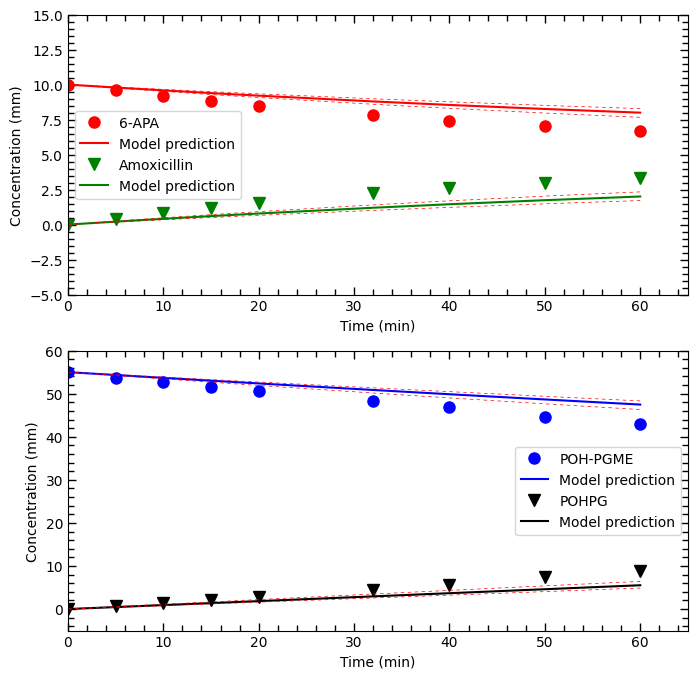

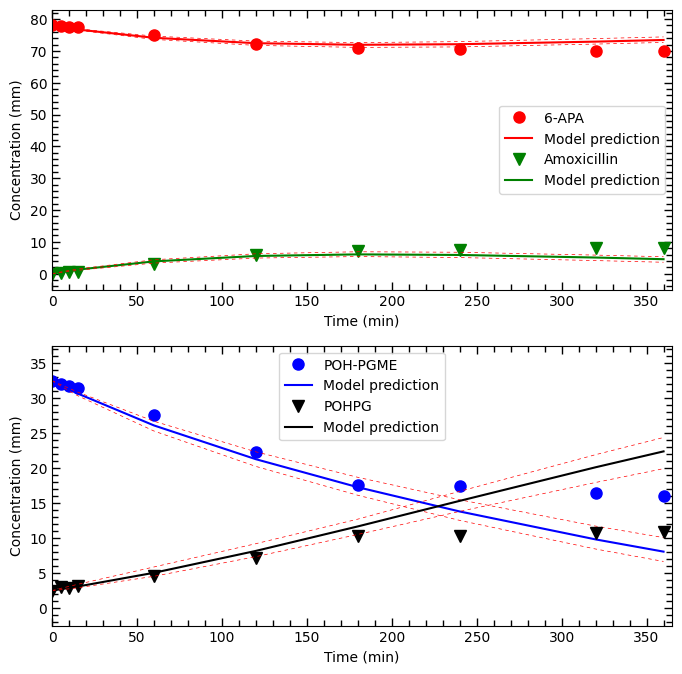

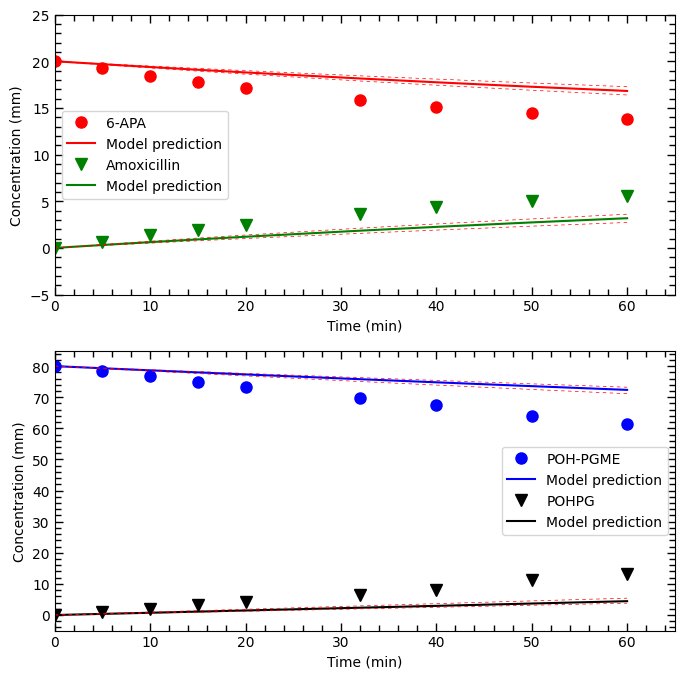

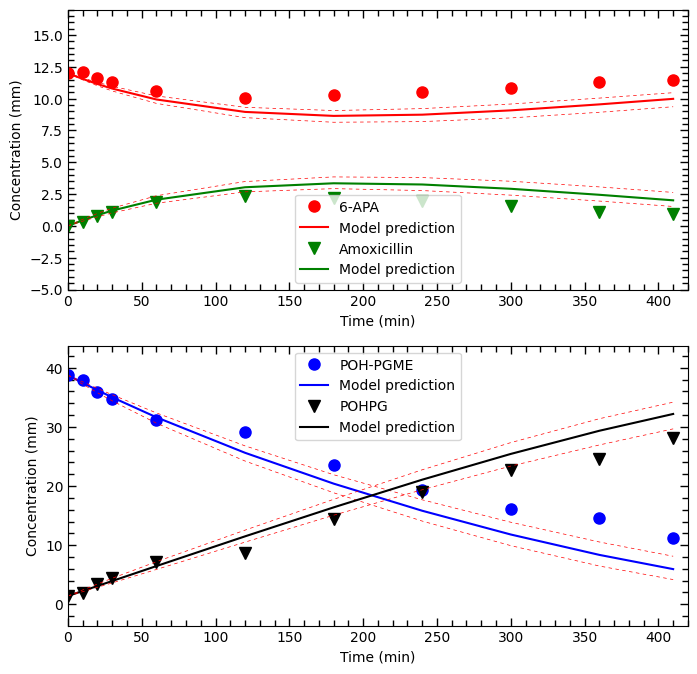

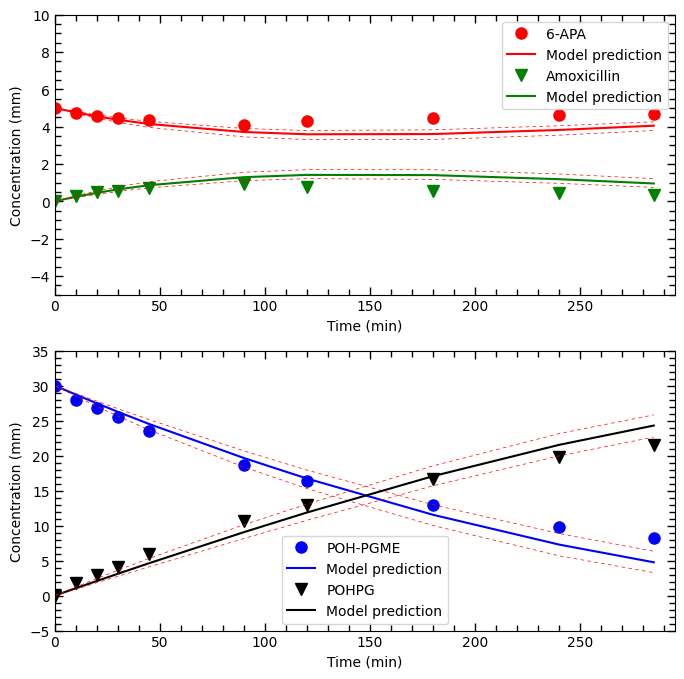

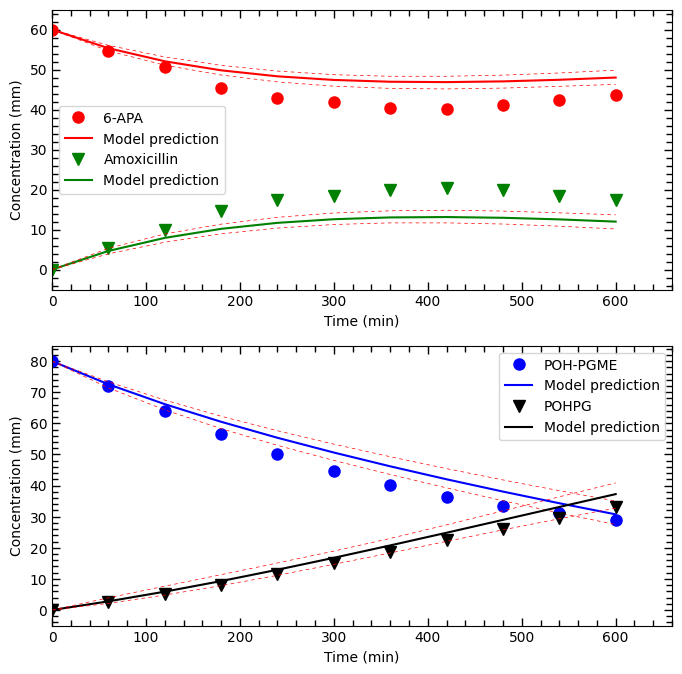

In [54]:
plot_with_ci('..\\results\\pickles\\rep\\0_50000_luci_5.100nh40ab80.npz',model=luci_model,path_to_save='..//results//compare//model_luci')

25.45nh60ab20
25.46nh30ab30
25.47nh5ab801
5.100nh40ab80
5.102nh20ab40
5.103nh40ab30
5.106nh100ab40
5.107nh55ab55
5.109nh5ab551
5.110nh10ab55
5.112nh78ab35
5.48nh20ab801
5.80nh12ab401
5.81nh5ab3001
nh60ab80 5001
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_25.45nh60ab20_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_25.46nh30ab30_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_25.47nh5ab80_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_5.100nh40ab80_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_5.102nh20ab40_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_5.103nh40ab30_mcmc.png
Figure saved successfully.
Saving figure to ..//results//compare//mcdonald\5.100nh40ab80_5001_5.106nh100ab40_mcmc.p

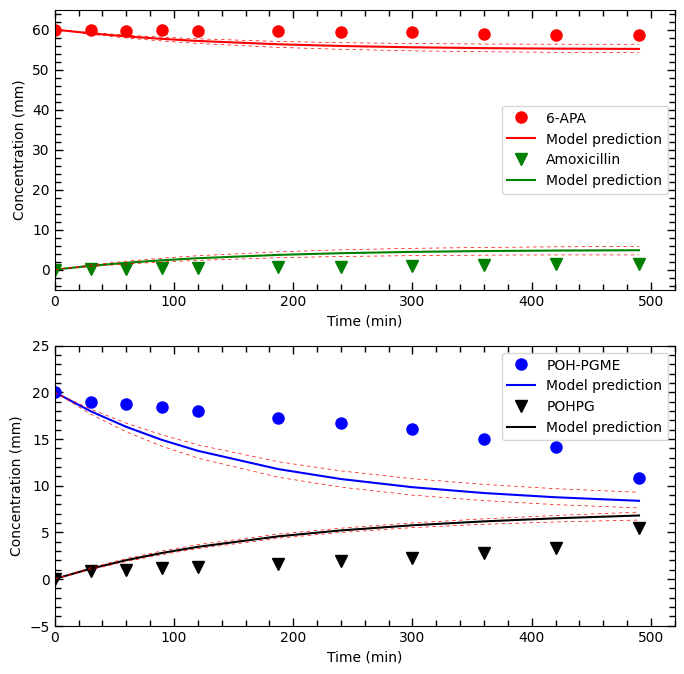

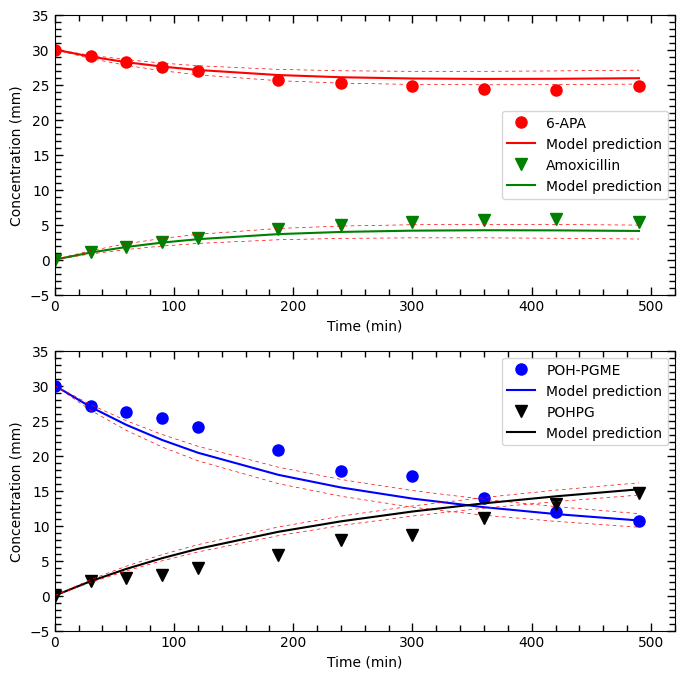

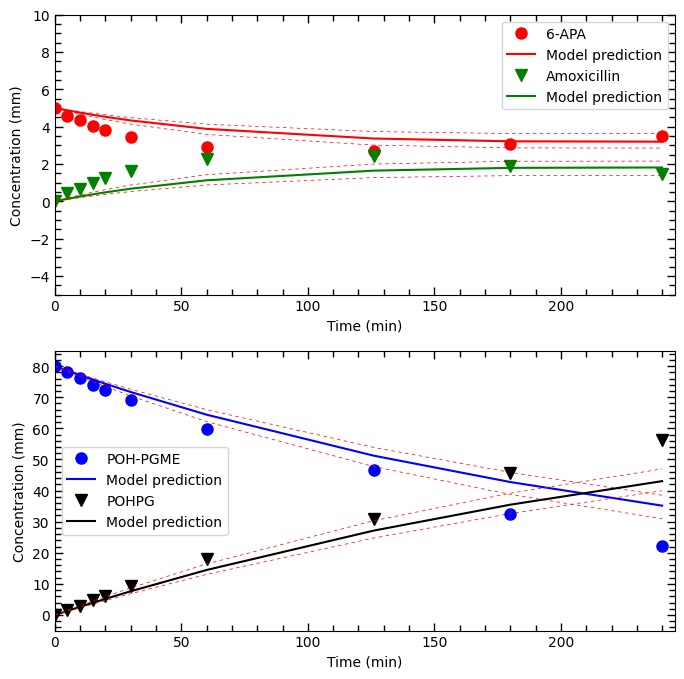

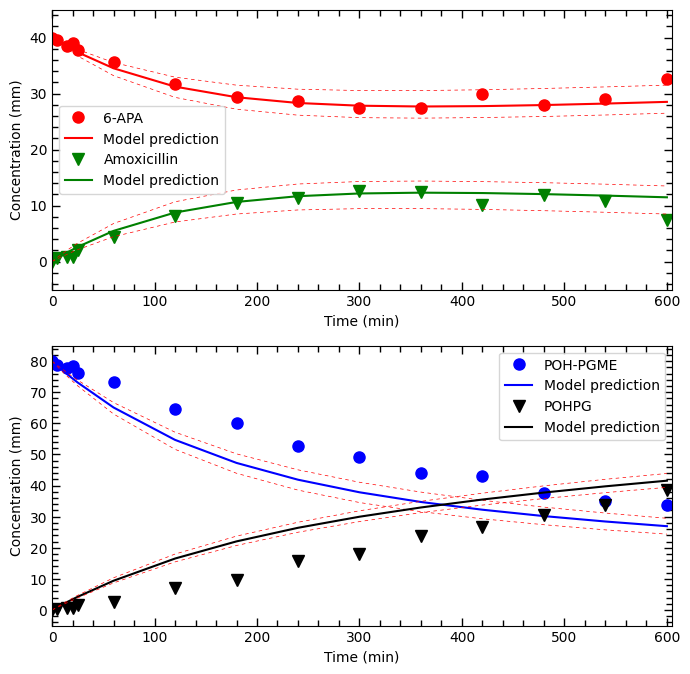

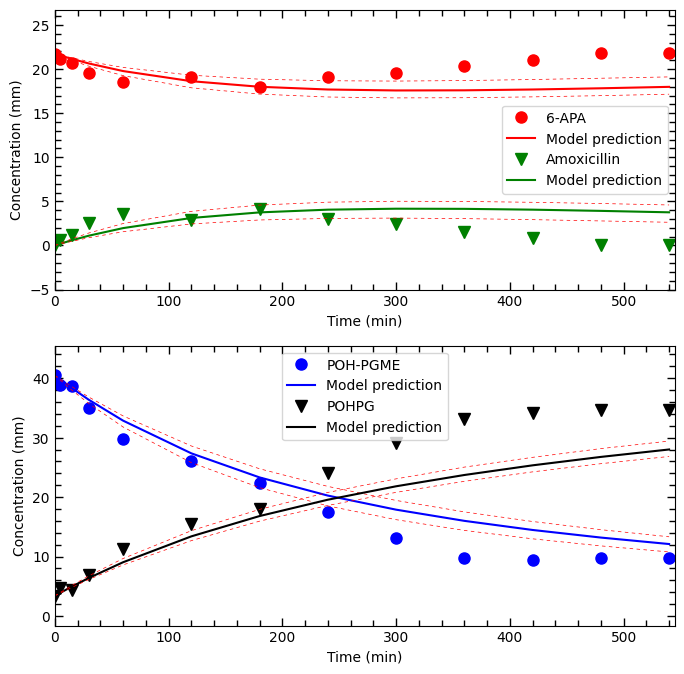

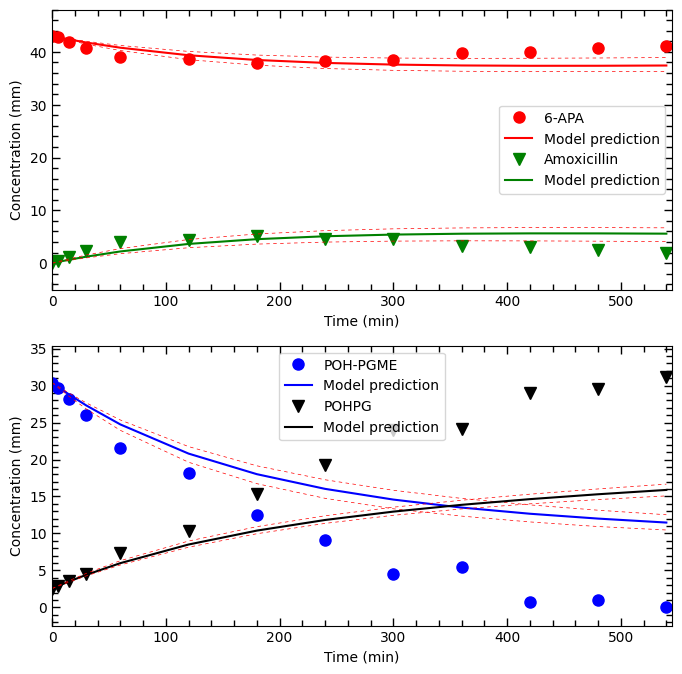

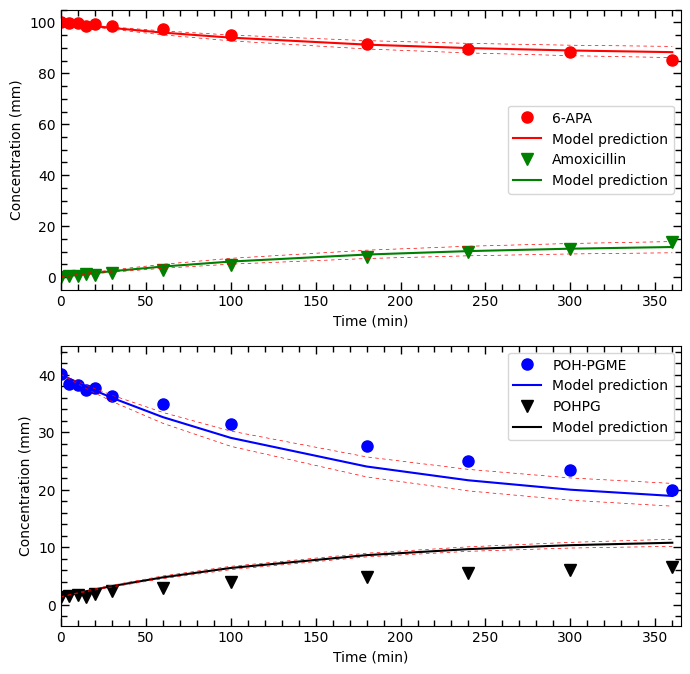

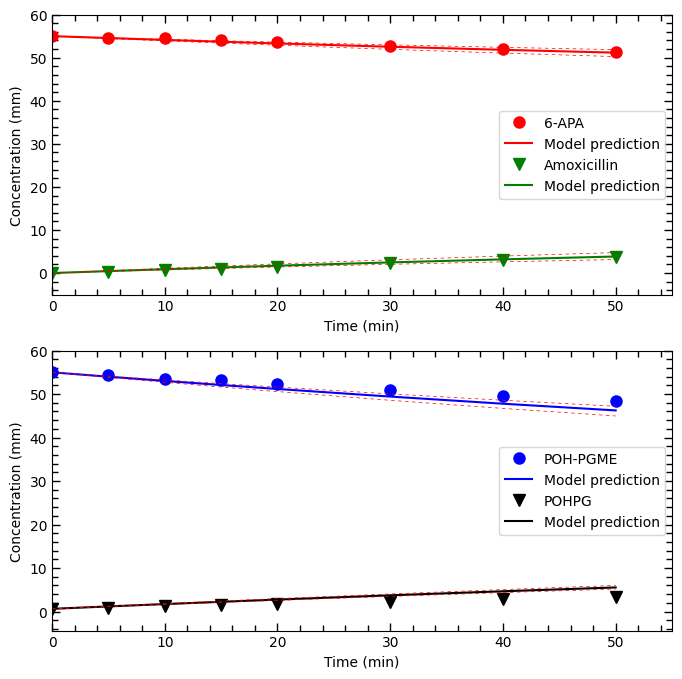

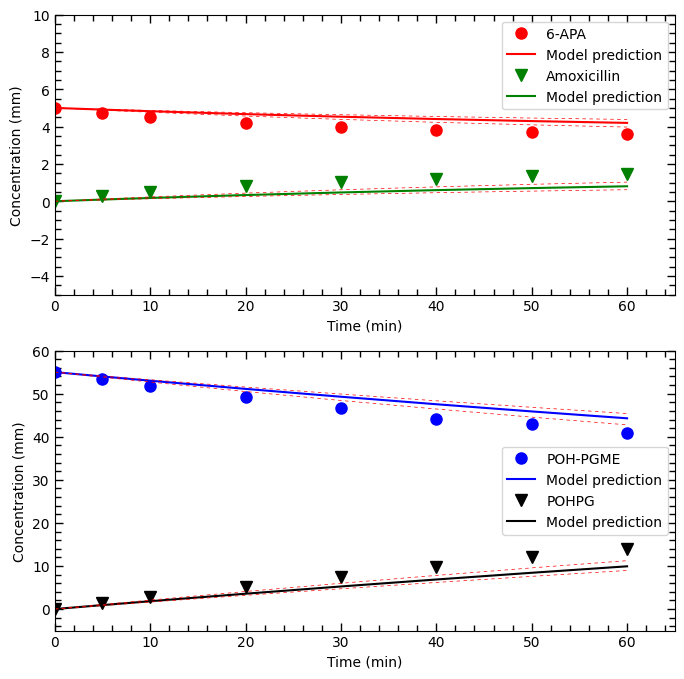

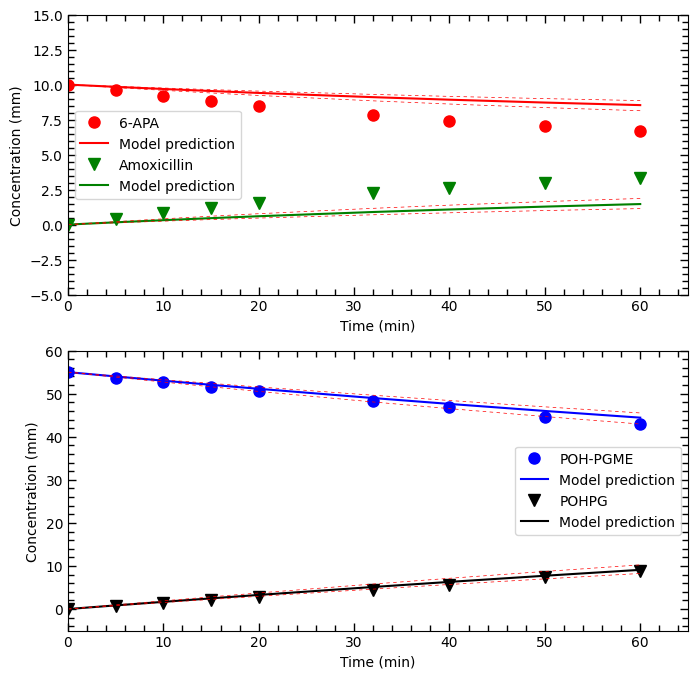

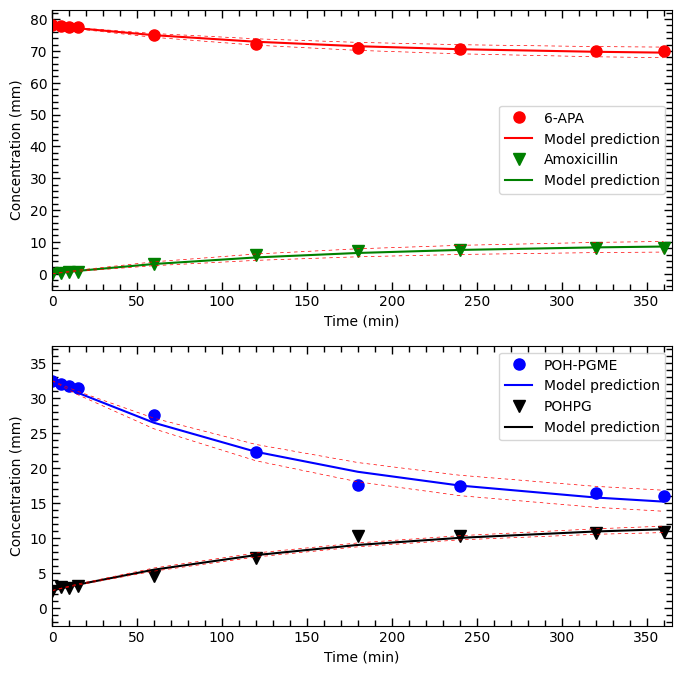

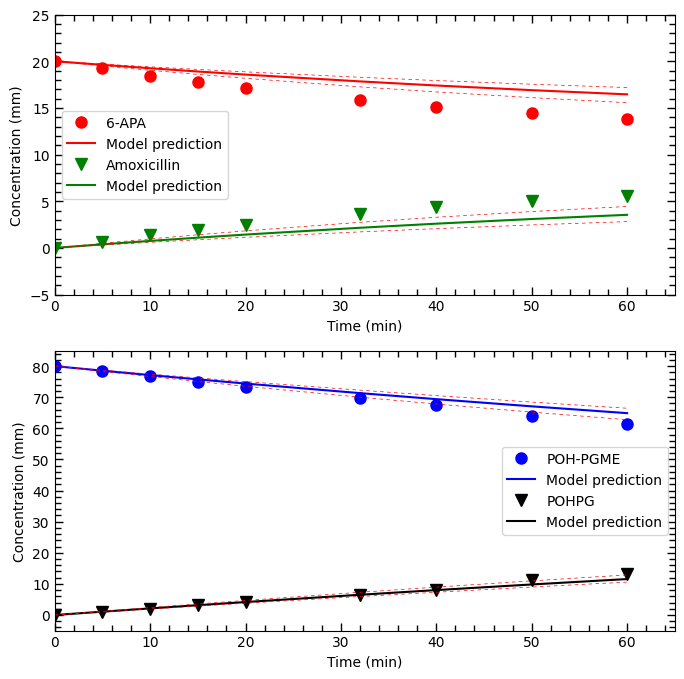

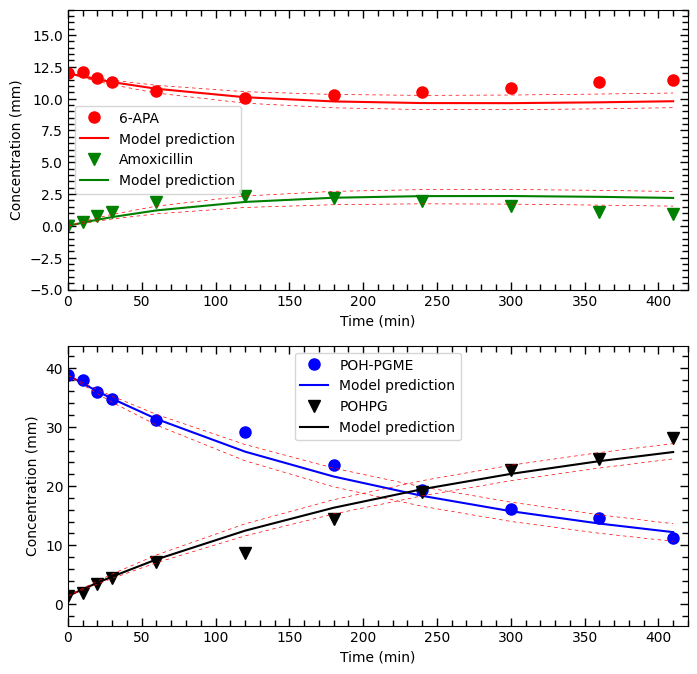

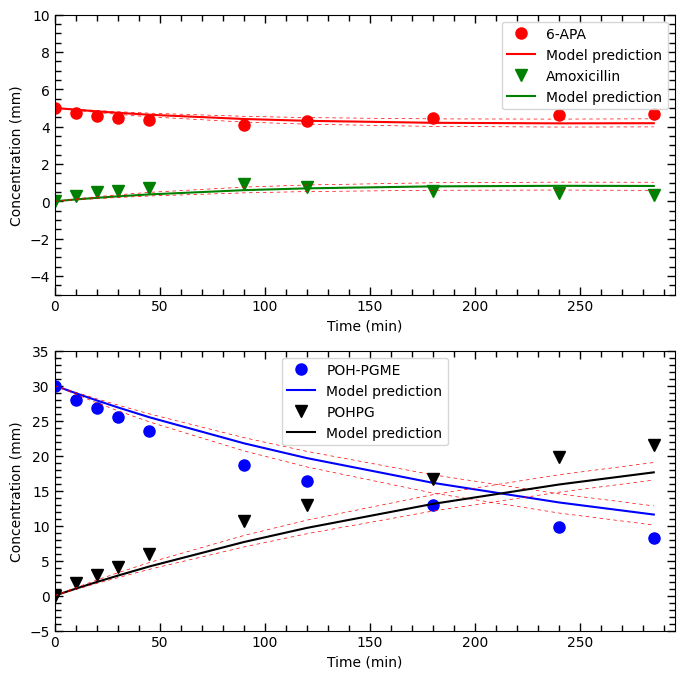

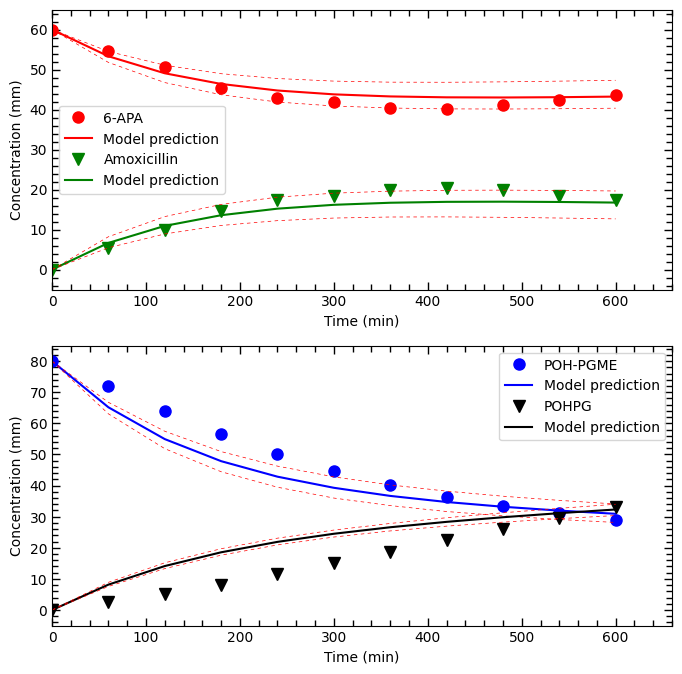

In [55]:
plot_with_ci('..\\results\\pickles\\donald\\1_50000_donald_5.112nh78ab35.npz',model=mcd_model,path_to_save='..//results//compare//mcdonald')

In [24]:
model = mcd_model
import matplotlib.pyplot as plt
from scipy.special import jv
import matplotlib as mpl

n = -4
P_cur = copy.deepcopy(ensaios_dfs_mcd_50k[eval_set[n]].iloc[1,:].to_list())
for i in range(len(CIs)):
    names = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    t = all_times[i]
    style = ['vb','og','vr','om']
    mstyle = ['-k','-k','-k','-k']
  
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']
    x_target = data_frames[file_list_exp[i]].loc[:,x_names].to_numpy()
    t_target = data_frames[file_list_exp[i]]['apa_t'].to_numpy()
    ic = x_target[0]

    sol_val = ode15s_amox(P_cur,ic,t_target,model)
    x_model = sol_val
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    for idx, axis in enumerate(ax.flatten()):
        sname = names[idx]
        sname2 = names[idx+2]
        
        axis.plot(t, data_frames[file_list_exp[i]].iloc[:, idx].to_numpy(), style[idx], label=sname,markersize=8)
        axis.plot(t, x_model[:,idx], mstyle[idx],label='Model prediction')
        axis.plot(t, data_frames[file_list_exp[i]].iloc[:, idx+1].to_numpy(), style[idx+1], label=sname2,markersize=8)
        axis.plot(t, x_model[:,idx+1], mstyle[idx+1],label='Model prediction')
        axis.tick_params(axis='both', which='major', direction='in', length=6, width=1)
        axis.tick_params(axis='both', which='minor', direction='in', length=4, width=1)

        # Enabling and customizing minor ticks
        axis.minorticks_on()

        # Ensuring ticks appear on all four sides of the plot
        axis.tick_params(top=True, bottom=True, left=True, right=True, which='both')
        axis.set_xlim([t[0],t[-1]+t[1]])
        axis.set_ylim([min(min(x_model[:,idx])-,min(x_model[:,idx+1])-1),max(max(x_model[:,idx]),max(x_model[:,idx+1]))+5])
        axis.set_xlabel('Time (min)')
        axis.set_ylabel(f'Concentration (mm)')
        axis.legend()
plt.show()

SyntaxError: invalid syntax (1277375977.py, line 39)